In [1]:
import os
from pathlib import Path

# Print the current working directory
starting_path = os.getcwd()

# Change directory to sleap-roots
if os.path.basename(os.getcwd()) == "sleap-roots":
    pass
else:
    os.chdir("..")
    
current_path = os.getcwd()

print(f"Starting directory: {starting_path}")
print(f"Changed to directory: {current_path}")

import pandas as pd
import numpy as np

import sleap_roots as sr
import sleap_io as sio

from sleap_roots.series import *
from sleap_roots.trait_pipelines import *
from sleap_roots.points import *
from sleap_roots.angle import *
from sleap_roots.scanline import *
from sleap_roots.bases import *
from sleap_roots.tips import *

Starting directory: c:\repos\sleap-roots\notebooks
Changed to directory: c:\repos\sleap-roots


In [68]:
class PrimaryRootPipeline(Pipeline):
    """Pipeline for computing traits for a single primary root."""

    def define_traits(self) -> List[TraitDef]:
        """Define the trait computation pipeline for primary roots."""
        trait_definitions = [
            TraitDef(
                name="primary_max_length_pts",
                fn= get_max_length_pts,
                input_traits=["primary_pts"],
                scalar=False,
                include_in_csv=False,
                kwargs={},
                description="",
            ),
            TraitDef(
                name="primary_proximal_node_ind",
                fn=get_node_ind,
                input_traits=["primary_max_length_pts"],
                scalar=True,
                include_in_csv=False,
                kwargs={"proximal": True},
                description="Get the indices of the proximal nodes of primary root.",
            ),
            TraitDef(
                name="primary_distal_node_ind",
                fn=get_node_ind,
                input_traits=["primary_max_length_pts"],
                scalar=True,
                include_in_csv=False,
                kwargs={"proximal": False},
                description="Get the indices of the distal nodes of primary roots.",
            ),
            TraitDef(
                name="primary_angle_proximal",
                fn=get_root_angle,
                input_traits=["primary_max_length_pts", "primary_proximal_node_ind"],
                scalar=True,
                include_in_csv=True,
                kwargs={},
                description="Array of primary proximal angles in degrees "
                "`(instances,)`.",
            ),
            TraitDef(
                name="primary_angle_distal",
                fn=get_root_angle,
                input_traits=["primary_max_length_pts", "primary_distal_node_ind"],
                scalar=True,
                include_in_csv=True,
                kwargs={},
                description="Array of primary distal angles in degrees `(instances,)`.",
            ),
            TraitDef(
                name="primary_length",
                fn=get_root_lengths,
                input_traits=["primary_max_length_pts"],
                scalar=True,
                include_in_csv=True,
                kwargs={},
                description="Scalar of primary root length.",
            ),
            TraitDef(
                name="primary_base_pt",
                fn=get_bases,
                input_traits=["primary_max_length_pts"],
                scalar=False,
                include_in_csv=False,
                kwargs={},
                description="Primary root base point.",
            ),
            TraitDef(
                name="primary_tip_pt",
                fn=get_tips,
                input_traits=["primary_max_length_pts"],
                scalar=False,
                include_in_csv=False,
                kwargs={},
                description="Primary root tip point.",
            ),
            TraitDef(
                name="primary_base_pt_y",
                fn=get_base_ys,
                input_traits=["primary_base_pt"],
                scalar=True,
                include_in_csv=False,
                kwargs={},
                description="Y-coordinate of the primary root base node.",
            ),
            TraitDef(
                name="primary_tip_pt_y",
                fn=get_tip_ys,
                input_traits=["primary_tip_pt"],
                scalar=True,
                include_in_csv=True,
                kwargs={},
                description="Y-coordinate of the primary root tip node.",
            ),
            TraitDef(
                name="primary_base_tip_dist",
                fn=get_base_tip_dist,
                input_traits=["primary_base_pt", "primary_tip_pt"],
                scalar=True,
                include_in_csv=True,
                kwargs={},
                description="Scalar of distance from primary root base to tip.",
            ),
            TraitDef(
                name="curve_index",
                fn=get_curve_index,
                input_traits=["primary_length", "primary_base_tip_dist"],
                scalar=True,
                include_in_csv=True,
                kwargs={},
                description="Scalar of primary root curvature index.",
            )
        ]
        return trait_definitions
    
    def get_initial_frame_traits(self, plant: Series, frame_idx: int) -> Dict[str, Any]:
        """Return initial traits for a plant frame

        Args:
            Args:
            plant: The plant `Series` object.
            frame_idx: The index of the current frame.

        Returns:
            A dictionary of initial traits with key:
                - "primary_pts": Array of primary root points.
        """
        primary_pts = plant.get_primary_points(frame_idx)
        return {"primary_pts": primary_pts}

### Check that primary root calculation is the same compared to Dicot example

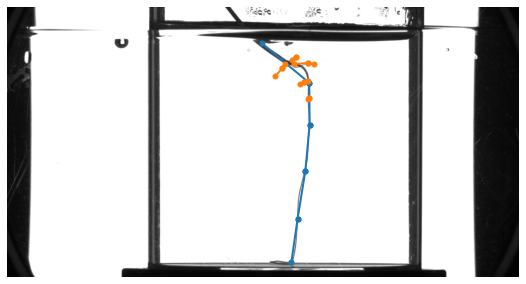

In [62]:
folder_path = "tests/data/canola_7do"
all_slps = sr.find_all_slp_paths(folder_path)

series = sr.load_series_from_slps(all_slps, h5s=True)[0]
series.plot(0, scale=0.25)

In [38]:
dicot_pipeline = DicotPipeline()
dicot_df = dicot_pipeline.compute_plant_traits(series)
dicot_df.head()
cols = ["plant_name", "frame_idx", "primary_angle_proximal", "primary_angle_distal", "primary_length", "primary_tip_pt_y", "primary_base_tip_dist", "curve_index"]
dicot_df_indexed = dicot_df.copy()[cols]

primary_root_pipeline = PrimaryRootPipeline()
primary_root_df = primary_root_pipeline.compute_plant_traits(series)
primary_root_df.head()

,plant_name,frame_idx,primary_angle_proximal,primary_angle_distal,primary_length,primary_tip_pt_y,primary_base_tip_dist,curve_index
0,919QDUH,0,50.131296,7.751131,971.050417,1020.981384,884.645018,0.088981
1,919QDUH,1,49.428952,7.274610,967.768886,1020.253540,883.227170,0.087357
2,919QDUH,2,49.549504,6.979000,971.479395,1019.996399,885.827768,0.088166
3,919QDUH,3,46.974455,5.701038,958.449865,1020.309387,880.393768,0.081440
4,919QDUH,4,45.006937,4.687666,951.056866,1024.859863,879.153473,0.075604


In [67]:
pd.testing.assert_frame_equal(dicot_df_indexed, primary_root_df)

### Check that primary root calculation is the same compared to YoungerMonocot example

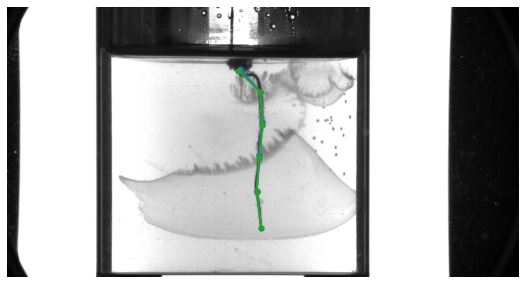

In [63]:
folder_path = "tests/data/rice_3do"
younger_monocot_slps = sr.find_all_slp_paths(folder_path)
all_younger_monocot_series = sr.load_series_from_slps(younger_monocot_slps, h5s=True)
series_0k9e5bi = [series for series in all_younger_monocot_series if series.series_name == "0K9E8BI"][0]

series_0k9e5bi.plot(0, scale=0.25)

In [65]:
younger_monocot_pipeline = YoungerMonocotPipeline()
younger_monocot_traits_df = younger_monocot_pipeline.compute_plant_traits(series_0k9e5bi)
younger_monocot_traits_df_indexed = younger_monocot_traits_df.copy()[cols]
younger_monocot_traits_df_indexed.head()

younger_monocot_prp_df = primary_root_pipeline.compute_plant_traits(series_0k9e5bi)
younger_monocot_prp_df.head()

,plant_name,frame_idx,primary_angle_proximal,primary_angle_distal,primary_length,primary_tip_pt_y,primary_base_tip_dist,curve_index
0,0K9E8BI,0,40.977192,7.518665,667.028374,884.077332,640.671225,0.039514
1,0K9E8BI,1,40.914564,7.918207,663.075476,884.658875,637.873340,0.038008
2,0K9E8BI,2,47.274641,9.989557,674.257100,880.961060,642.089682,0.047708
3,0K9E8BI,3,49.219042,10.666083,678.701746,884.188904,647.017462,0.046684
4,0K9E8BI,4,51.511266,11.671686,685.410121,880.787231,649.818719,0.051927


In [66]:
pd.testing.assert_frame_equal(younger_monocot_prp_df, younger_monocot_traits_df_indexed)